Seed set to 42


 NOTE: 734 lesions shared between TRAIN and VAL (image-level validation)


/home/.conda/envs/env/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:193: Found keys that are in the model state dict but not in the checkpoint: ['backbone.features.0.0.weight', 'backbone.features.0.1.weight', 'backbone.features.0.1.bias', 'backbone.features.0.1.running_mean', 'backbone.features.0.1.running_var', 'backbone.features.1.0.block.0.0.weight', 'backbone.features.1.0.block.0.1.weight', 'backbone.features.1.0.block.0.1.bias', 'backbone.features.1.0.block.0.1.running_mean', 'backbone.features.1.0.block.0.1.running_var', 'backbone.features.1.0.block.1.fc1.weight', 'backbone.features.1.0.block.1.fc1.bias', 'backbone.features.1.0.block.1.fc2.weight', 'backbone.features.1.0.block.1.fc2.bias', 'backbone.features.1.0.block.2.0.weight', 'backbone.features.1.0.block.2.1.weight', 'backbone.features.1.0.block.2.1.bias', 'backbone.features.1.0.block.2.1.running_mean', 'backbone.features.1.0.block.2.1.running_var', 'backbone.features.2.0.block.0.0.weight', 'backbone.features


Per-class report (lesion-level):
              precision    recall  f1-score   support

          NV      0.151     0.057     0.082       335
         MEL      0.087     0.022     0.035       185
         SCC      0.000     0.000     0.000        34
         BKL      0.043     0.023     0.030        87
         BCC      0.401     0.311     0.350       286
          AK      0.020     0.200     0.037        55
          DF      0.000     0.000     0.000         5

    accuracy                          0.127       987
   macro avg      0.100     0.088     0.076       987
weighted avg      0.189     0.127     0.141       987

Lesion-level balanced accuracy: 0.08750219378114386

Per-class report (image-level):
              precision    recall  f1-score   support

          NV      0.152     0.053     0.079      1112
         MEL      0.167     0.027     0.047       918
         SCC      0.000     0.000     0.000       109
         BKL      0.045     0.025     0.032       241
         BCC 

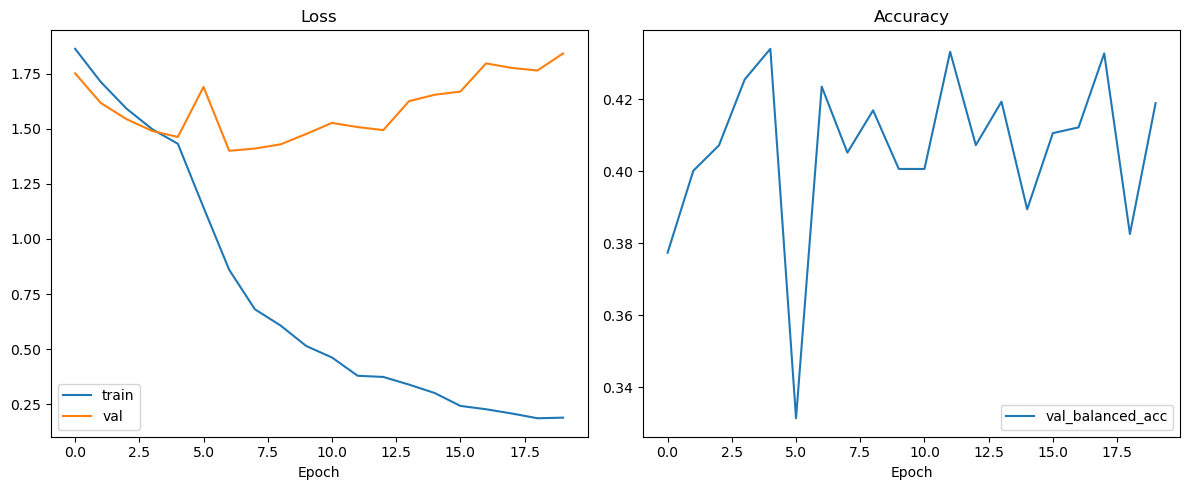

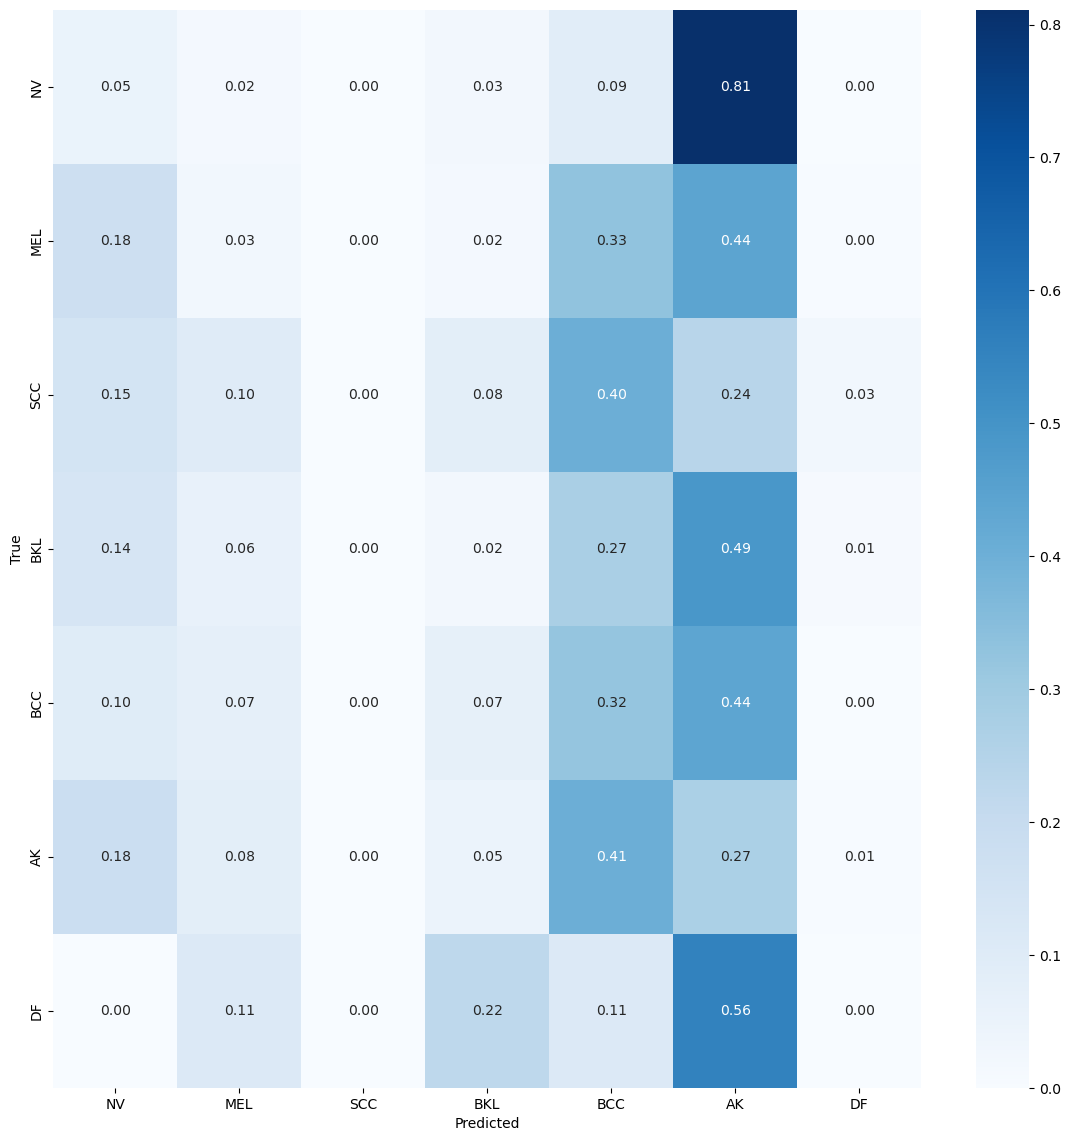

In [1]:
# classifier/eval.py

from pathlib import Path
import pytorch_lightning as pl
import torch

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from config import *
from data.splits import create_splits, create_splits_from_file
from data.transforms import get_transforms
from data.datamodule import ImageDataModule
from models.efficientnet import EfficientNetLit
from utils.plots import plot_metrics, plot_confusion_matrix
from utils.seed import set_seed
from sklearn.metrics import classification_report



def main():
    set_seed(SEED)

    LOG_DIR = Path("logs/efficientnet/fold_2")
    CKPT_PATH = LOG_DIR / "checkpoints"
    CKPT_PATH = list(CKPT_PATH.glob("*.ckpt"))[0]

    fold =2
    train_df, val_df, test_df, classes = create_splits_from_file(
        split_csv=SPLIT_FILE,
        images_dir=METADATA_DIR,
        fold=fold,
    )

    classes_map = dict(zip(train_df['label'], train_df['diagnosis']))
    classes = [classes_map[i] for i in sorted(classes_map.keys())]

    train_tfms, val_tfms = get_transforms()

    datamodule = ImageDataModule(
        train_df,
        val_df,
        test_df,
        train_tfms,
        val_tfms,
        BATCH_SIZE,
        NUM_WORKERS,
    )

    # 4. загрузка модели
    model = EfficientNetLit.load_from_checkpoint(
        CKPT_PATH,
        num_classes=len(classes),
        lr=LR,
        strict=False,
    )


    model.eval()
    preds, targets = [], []

    datamodule.setup(stage="test") 
    
    for x, y in datamodule.test_dataloader():
        x, y = x.to(model.device), y.to(model.device)  # если есть GPU
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(1)
        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

    # 1. Берём test_df, который соответствует test_dataloader
    df = test_df.copy().reset_index(drop=True)
    
    # 2. Добавляем предсказания модели
    df["pred"] = preds
    
    # 3. Агрегация по lesion_id (majority vote)
    lesion_preds = (
        df.groupby("lesion_id")["pred"]
          .agg(lambda x: np.bincount(x).argmax())
    )
    
    lesion_targets = (
        df.groupby("lesion_id")["label"]
          .first()
    )

    print("\nPer-class report (lesion-level):")
    print(
        classification_report(
            lesion_targets,
            lesion_preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    
    # 4. Метрика как в статье
    bal_acc = balanced_accuracy_score(lesion_targets, lesion_preds)
    
    print("Lesion-level balanced accuracy:", bal_acc)

    OUTPUT_DIR = LOG_DIR / "figures"
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

    print("\nPer-class report (image-level):")
    print(
        classification_report(
            targets,
            preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    
    plot_metrics(LOG_DIR, save_path=OUTPUT_DIR / "metrics.pdf")
    plot_confusion_matrix(targets, preds, classes, save_path=OUTPUT_DIR / "confusion_matrix.pdf")
    

if __name__ == "__main__":
    main()


Seed set to 42



Per-class report (image-level):
              precision    recall  f1-score   support

          AK      0.412     0.780     0.539       232
         BCC      0.754     0.714     0.733       733
         BKL      0.593     0.536     0.563       332
          DF      0.604     0.879     0.716        33
         MEL      0.811     0.563     0.665       916
          NV      0.796     0.848     0.821      1180
         SCC      0.535     0.760     0.628       121

    accuracy                          0.710      3547
   macro avg      0.644     0.726     0.667      3547
weighted avg      0.736     0.710     0.712      3547

Image-level balanced accuracy: 0.7257950643713046

Per-class report (lesion-level):
              precision    recall  f1-score   support

          AK      0.345     0.762     0.475        63
         BCC      0.771     0.736     0.753       261
         BKL      0.576     0.521     0.547        94
          DF      0.692     0.818     0.750        11
         MEL   

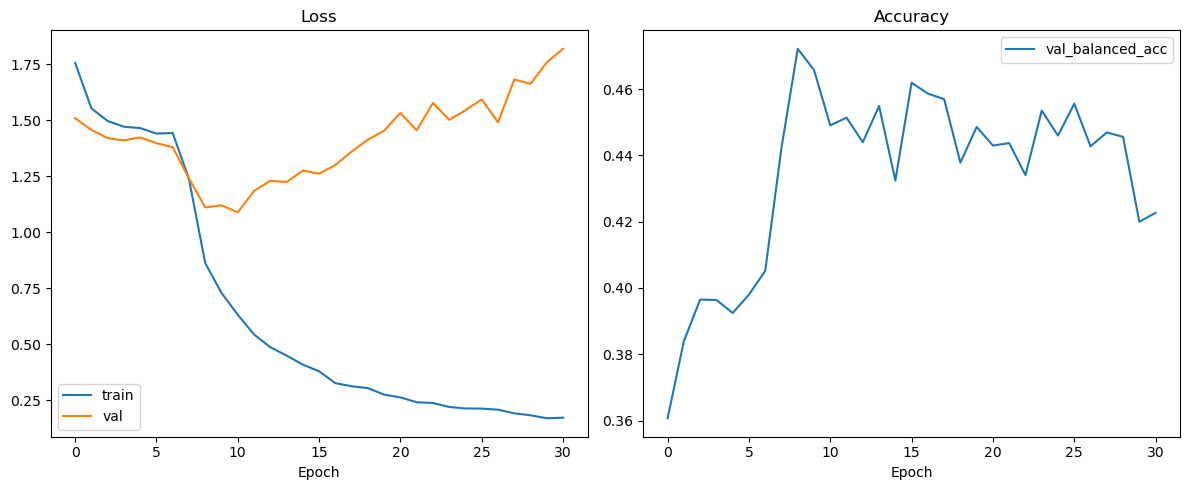

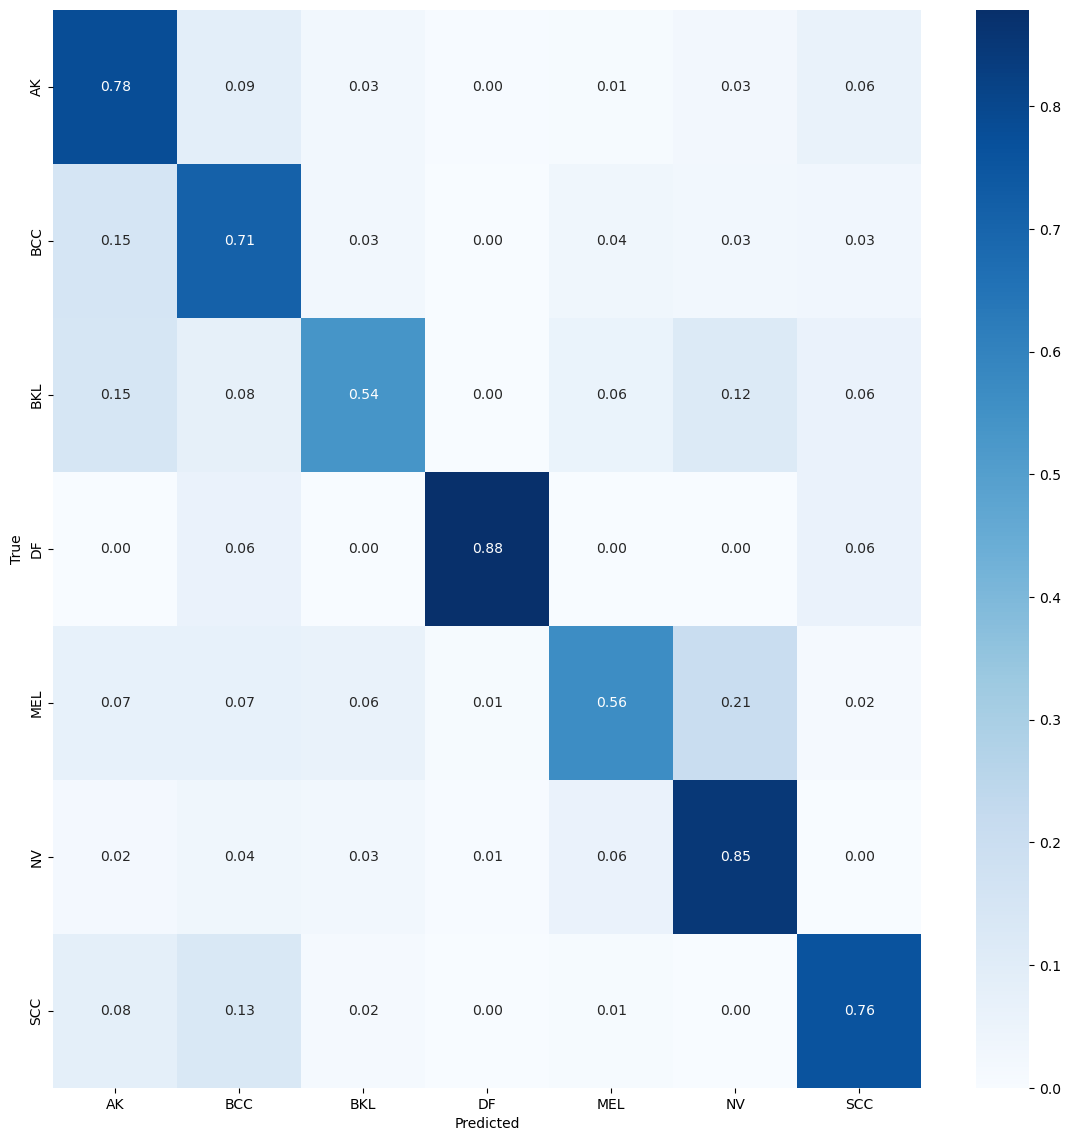

In [1]:
from pathlib import Path
import pytorch_lightning as pl
import torch

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from config import *
from data.splits import create_splits, create_splits_from_file, create_lesion_kfold_splits, create_lesion_1_img
from data.transforms import get_transforms
from data.datamodule import ImageDataModule
from models.efficientnet import EfficientNetLit
from utils.plots import plot_metrics, plot_confusion_matrix
from utils.seed import set_seed
from sklearn.metrics import classification_report


def main():
    set_seed(SEED)

    fold = 1  # <<< МЕНЯЕШЬ ФОЛД ЗДЕСЬ

    LOG_DIR = Path(f"logs/efficientnet/split_{fold}")
    CKPT_DIR = LOG_DIR / "checkpoints"
    CKPT_PATH = next(CKPT_DIR.glob("best*.ckpt"))

    train_df, val_df, test_df, classes = create_lesion_kfold_splits(
        metadata_csv=METADATA_DIR,
        images_dir=METADATA_DIR,
        seed=SEED,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        n_folds=N_FOLDS,
        fold=fold,
    )

    train_tfms, val_tfms = get_transforms()

    datamodule = ImageDataModule(
        train_df,
        val_df,
        test_df,
        train_tfms,
        val_tfms,
        BATCH_SIZE,
        NUM_WORKERS,
    )

    model = EfficientNetLit.load_from_checkpoint(
        CKPT_PATH,
        num_classes=len(classes),
        lr=LR,
        strict=True,
    )

    model.eval()
    preds, targets = [], []

    datamodule.setup(stage="test")

    for x, y in datamodule.test_dataloader():
        x, y = x.to(model.device), y.to(model.device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(1)

        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

    # -------------------------
    # IMAGE-LEVEL → LESION-LEVEL
    # -------------------------
    image_bal_acc = balanced_accuracy_score(targets, preds)

    print("\nPer-class report (image-level):")
    print(
        classification_report(
            targets,
            preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    print("Image-level balanced accuracy:", image_bal_acc)

    
    df = test_df.copy().reset_index(drop=True)
    df["pred"] = preds

    lesion_preds = (
        df.groupby("lesion_id")["pred"]
        .agg(lambda x: np.bincount(x).argmax())
    )

    lesion_targets = (
        df.groupby("lesion_id")["label"].first()
    )

    print("\nPer-class report (lesion-level):")
    print(
        classification_report(
            lesion_targets,
            lesion_preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    bal_acc = balanced_accuracy_score(lesion_targets, lesion_preds)
    print("Lesion-level balanced accuracy:", bal_acc)

    OUTPUT_DIR = LOG_DIR / "figures"
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

    
    
    plot_metrics(LOG_DIR, save_path=OUTPUT_DIR / "metrics.pdf")
    plot_confusion_matrix(targets, preds, classes, save_path=OUTPUT_DIR / "confusion_matrix.pdf")
    

if __name__ == "__main__":
    main()


Seed set to 42


 NOTE: 700 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 734 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 731 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 735 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 728 lesions shared between TRAIN and VAL (image-level validation)


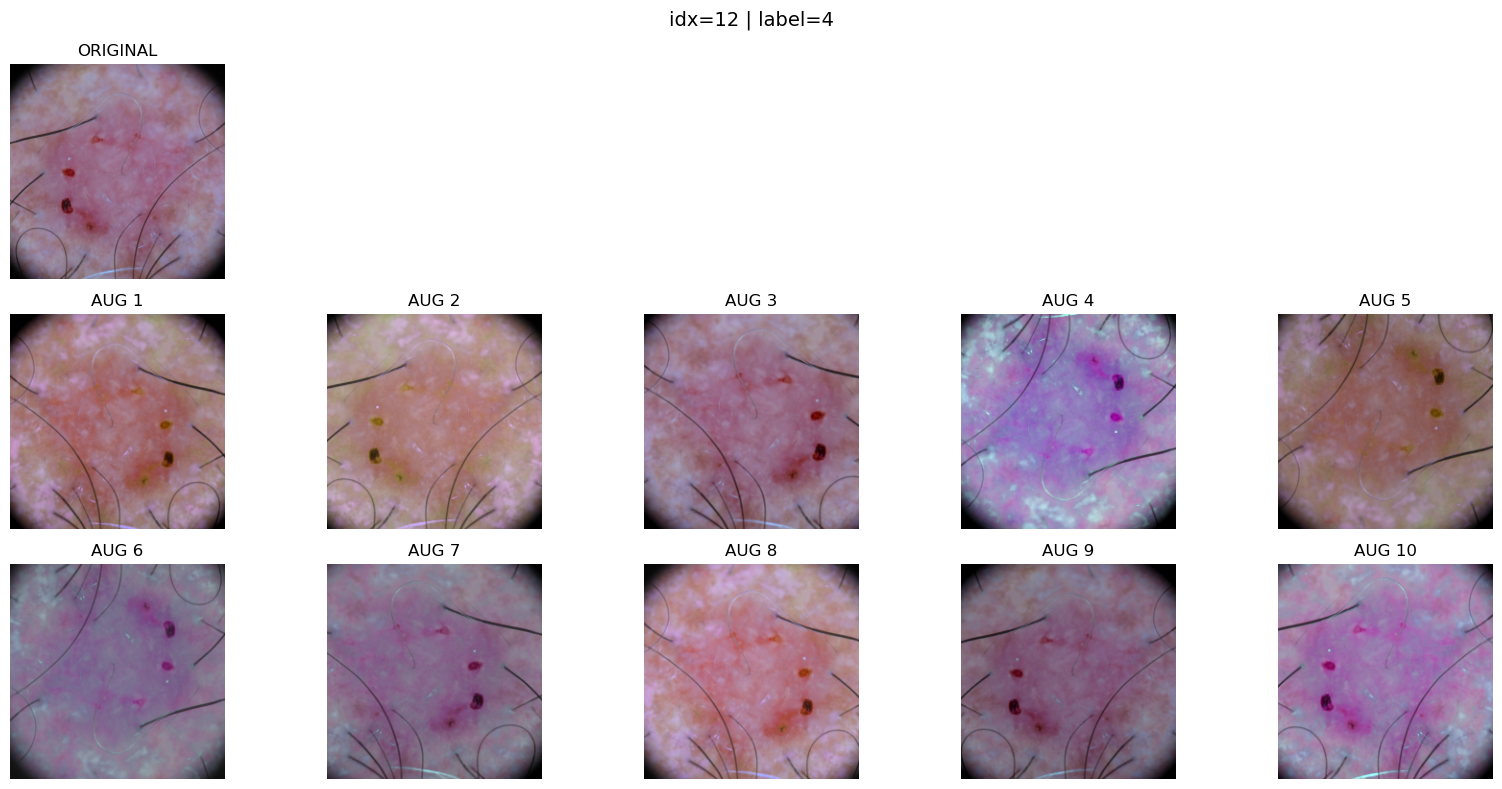

In [3]:
# classifier/inspect_transforms.py

import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

from config import *
from data.splits import create_splits_from_file
from data.transforms import get_transforms
from utils.seed import set_seed


def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


def find_image_path(row, images_dir):
    """
    Находит изображение по bcn_filename / isic_id
    """
    exts = ["", ".jpg", ".png", ".jpeg"]

    # 1. Явно берём имя файла
    candidates = []

    if "bcn_filename" in row:
        candidates.append(row["bcn_filename"])

    if "isic_id" in row:
        candidates.append(row["isic_id"])

    # 2. Пробуем разные варианты путей
    for name in candidates:
        for ext in exts:
            fname = name if name.endswith(ext) else name + ext

            paths = [
                os.path.join(images_dir, fname),
                os.path.join(images_dir, "images", fname),
                os.path.join(images_dir, "ISIC_Images", fname),
            ]

            for p in paths:
                if os.path.isfile(p):
                    return p

    raise FileNotFoundError(
        f"Не удалось найти файл изображения.\n"
        f"bcn_filename={row.get('bcn_filename')}\n"
        f"isic_id={row.get('isic_id')}\n"
        f"images_dir={images_dir}"
    )




def main():
    set_seed(SEED)

    for fold in range(1, 6):
        train_df, val_df, test_df, classes = create_splits_from_file(
            split_csv=SPLIT_FILE,
            images_dir=METADATA_DIR,
            fold=fold,
        )

    train_tfms, _ = get_transforms()

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    # выбираем конкретный индекс
    idx = 12         
    row = train_df.iloc[idx]

    img_path = find_image_path(row, METADATA_DIR)
    label = row["label"]

    img_pil = Image.open(img_path).convert("RGB")

    # ---------- ВИЗУАЛИЗАЦИЯ ----------
    plt.figure(figsize=(16, 8))

    # ОРИГИНАЛ
    plt.subplot(3, 5, 1)
    plt.imshow(img_pil)
    plt.title("ORIGINAL")
    plt.axis("off")

    #  АУГМЕНТАЦИИ
    for i in range(10):
        img = train_tfms(img_pil)
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(3, 5, i + 6)
        plt.imshow(img)
        plt.title(f"AUG {i+1}")
        plt.axis("off")

    plt.suptitle(
        f"idx={idx} | label={classes[label]}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [2]:
import pandas as pd

# Пути к файлам
ORIG_METADATA_PATH = "/home/project/experiment/BCN20000/bcn20000_metadata.csv"
SPLIT_PATH = "/home/project/experiment/BCN20000/master_split_file_3.csv"

# --- 1. Загружаем данные ---
orig_df = pd.read_csv(ORIG_METADATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)

# --- 2. Приводим ключи к одному виду ---
# из bcn_filename -> isic_id (убираем .jpg)
split_df["isic_id"] = split_df["bcn_filename"].str.replace(".jpg", "", regex=False)

# --- 3. Берём только нужные колонки ---
orig_sub = orig_df[["isic_id", "diagnosis_3"]]
split_sub = split_df[["isic_id", "diagnosis"]]

# --- 4. Мёрджим ---
merged = orig_sub.merge(split_sub, on="isic_id", how="inner")

# --- 5. Убираем пустые диагнозы (опционально, но полезно) ---
merged = merged.dropna(subset=["diagnosis_3", "diagnosis"])

# --- 6. Смотрим соответствие ---
mapping = (
    merged[["diagnosis_3", "diagnosis"]]
    .drop_duplicates()
    .sort_values(["diagnosis", "diagnosis_3"])
    .reset_index(drop=True)
)

print("\n=== diagnosis_3 → diagnosis ===\n")
print(mapping)

# --- 7. (Бонус) То же самое, но в виде сводной таблицы ---
print("\n=== Crosstab ===\n")
print(pd.crosstab(merged["diagnosis_3"], merged["diagnosis"]))



=== diagnosis_3 → diagnosis ===

                    diagnosis_3 diagnosis
0    Solar or actinic keratosis        AK
1          Basal cell carcinoma       BCC
2          Seborrheic keratosis       BKL
3                 Solar lentigo       BKL
4                Dermatofibroma        DF
5           Melanoma metastasis       MEL
6                 Melanoma, NOS       MEL
7                         Nevus        NV
8  Squamous cell carcinoma, NOS       SCC

=== Crosstab ===

diagnosis                       AK    BCC   BKL   DF    MEL     NV   SCC
diagnosis_3                                                             
Basal cell carcinoma             0  18380     0    0      0      0     0
Dermatofibroma                   0      0     0  840      0      0     0
Melanoma metastasis              0      0     0    0   3165      0     0
Melanoma, NOS                    0      0     0    0  20015      0     0
Nevus                            0      0     0    0      0  28235     0
Seborrheic kerat

In [3]:
import pandas as pd
SPLIT_PATH = "/home/project/experiment/BCN20000/master_split_file_3.csv"


df = pd.read_csv(SPLIT_PATH)

dup_ids = (
    df["lesion_id"]
    .value_counts()
    .loc[lambda x: x > 1]
    .index
)

print(f"repeated lesion_id: {len(dup_ids)}")

sample_ids = dup_ids[:5]

duplicates_df = df[df["lesion_id"].isin(sample_ids)] \
    .sort_values(["lesion_id", "fold_number", "split_type"])

print(duplicates_df)


repeated lesion_id: 4933
           bcn_filename  age_approx anatom_site_general diagnosis   lesion_id  \
507    ISIC_0054026.jpg        55.0     lower extremity       MEL  IL_2969638   
589    ISIC_0054117.jpg        55.0     lower extremity       MEL  IL_2969638   
679    ISIC_0054222.jpg        55.0     lower extremity       MEL  IL_2969638   
932    ISIC_0054512.jpg        55.0     lower extremity       MEL  IL_2969638   
957    ISIC_0054540.jpg        55.0     lower extremity       MEL  IL_2969638   
...                 ...         ...                 ...       ...         ...   
73029  ISIC_0057727.jpg        35.0           head/neck       MEL  IL_9292662   
75637  ISIC_0060703.jpg        35.0           head/neck       MEL  IL_9292662   
75736  ISIC_0060817.jpg        35.0           head/neck       MEL  IL_9292662   
77971  ISIC_0063373.jpg        35.0           head/neck       MEL  IL_9292662   
82155  ISIC_0068115.jpg        35.0           head/neck       MEL  IL_9292662   

  

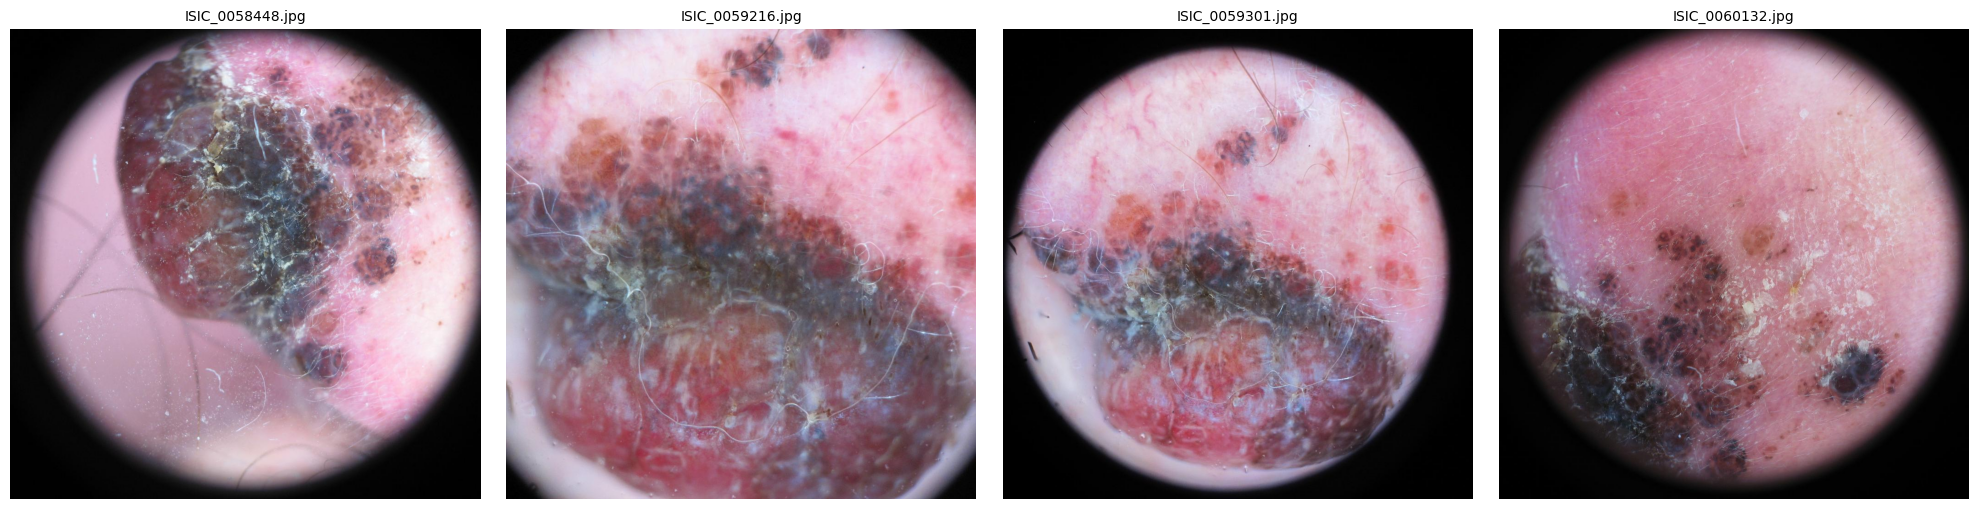

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

IMAGES_DIR = Path("/home/project/BCN20000/")

files_to_show = [
    "ISIC_0058448.jpg",
    "ISIC_0059216.jpg",
    "ISIC_0059301.jpg",
    "ISIC_0060132.jpg",
]

n = len(files_to_show)
plt.figure(figsize=(5 * n, 5))

for i, fname in enumerate(files_to_show):
    img_path = IMAGES_DIR / fname

    if not img_path.exists():
        print(f"Файл не найден: {img_path}")
        continue

    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(fname, fontsize=10)

plt.tight_layout()
plt.show()
